<a href="https://colab.research.google.com/github/HammadN98/pytorch/blob/main/06_pytorch_transfer_learning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 6. Pytorch Tranfer Learning

O que eh Transfer Learning?

Transfer Learning envolve pegar os parametros de um modelo que foi trainado em outros dataset e aplicar-los no nosso proprio ploblema

* Pretrained model = foundation models

In [1]:
import torch
import torchvision

print(torch.__version__)
print(torchvision.__version__)


2.4.1+cu121
0.19.1+cu121


In [2]:
#COpiado da estrutura do curso, modificado apenas para manter a pasta "data" ao baixar o repositorio para o collab
# Continue with regular imports
import matplotlib.pyplot as plt
import torch
import torchvision

from torch import nn
from torchvision import transforms

# Try to get torchinfo, install it if it doesn't work
try:
    from torchinfo import summary
except:
    print("[INFO] Couldn't find torchinfo... installing it.")
    !pip install -q torchinfo
    from torchinfo import summary

# Try to import the going_modular directory, download it from GitHub if it doesn't work
try:
    from going_modular.going_modular import data_setup, engine
except:
    # Get the going_modular scripts
    print("[INFO] Couldn't find going_modular scripts... downloading them from GitHub.")
    !git clone https://github.com/mrdbourke/pytorch-deep-learning
    !mv pytorch-deep-learning/going_modular .

    #!mv pytorch-deep-learning/data .

    !rm -rf pytorch-deep-learning
    from going_modular.going_modular import data_setup, engine

[INFO] Couldn't find torchinfo... installing it.
[INFO] Couldn't find going_modular scripts... downloading them from GitHub.
Cloning into 'pytorch-deep-learning'...
remote: Enumerating objects: 4356, done.
remote: Counting objects: 100% (321/321), done.
remote: Compressing objects: 100% (142/142), done.
remote: Total 4356 (delta 213), reused 254 (delta 178), pack-reused 4035 (from 1)
Receiving objects: 100% (4356/4356), 654.51 MiB | 21.68 MiB/s, done.
Resolving deltas: 100% (2585/2585), done.
Updating files: 100% (248/248), done.


In [3]:
#COnfigurando o dispositivo
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

# 1. Conseguindo os dados

Baixandoi os dados: Pizza, Steak, Sushi para construir um modelo com transfer learning

In [4]:
import os
import zipfile
import requests

from pathlib import Path



#Configurando o caminho
data_path = Path("data/")
image_path = data_path / "pizza_steak_sushi"

#Se a pasta das imagens nao existe, baixar e prepara
if image_path.is_dir():
  print(f"Diretrio {image_path} existe, pulando download...")
else:
  print(f"O diretorio {image_path} nao foi encontrado, baixando...")
  image_path.mkdir(parents=True, exist_ok=True)

  #Baixando dados -> pizza, steak, sushi
  with open(data_path / "pizza_steak_sushi.zip", "wb") as f:
    request = requests.get("https://github.com/mrdbourke/pytorch-deep-learning/raw/main/data/pizza_steak_sushi.zip")
    print("Baixando pizza, steak, sushi...")
    f.write(request.content)

  # Unzip pizza, steak, sushi
  with zipfile.ZipFile(data_path / "pizza_steak_sushi.zip", "r") as zip_ref:
      print("Unzipping pizza, steak, sushi data...")
      zip_ref.extractall(image_path)

  # Remove .zip
  os.remove(data_path / "pizza_steak_sushi.zip")


O diretorio data/pizza_steak_sushi nao foi encontrado, baixando...
Baixando pizza, steak, sushi...
Unzipping pizza, steak, sushi data...


In [5]:
#Configurando caminho dos diretorios
train_dir = image_path / "train"
test_dir = image_path / "test"

train_dir, test_dir

(PosixPath('data/pizza_steak_sushi/train'),
 PosixPath('data/pizza_steak_sushi/test'))

# 2. Criando Datasets e DataLoaders

Agora que se tem os dados, vamos precisar transformar em DataLoaders Pytorch, e para isso sera utilizado o `datas_setup.py` e a funcao `create_dataloaders()`, que foi feita no modulo passado.

Uma coisa para se pensar eh, como iremos **transformar** os dados?

Apartir da versao 0.13+ do torchvision eh possivel fazer de duas maneiras:

1. Criar os transforms de maneira manual - Aonde definimos por quais trnasforms queremos que os dados passem.
2. De maneira automatica: Com base no modelo que sera usado, ele definira os transforms.

**NOTE** Quando usado um modelo pre-treinado, eh importante que os dados(incluindo os custom proprios) que iremos usar sejam trnassformados do mesma menira que os dados em que o modelo foi originalmente treinado.

## 2.1 Crianado transforms com `torchvision.models` (Maneira manual)

`torchvision.models` contem modelos pre-treinados(ou seja modelos pronto para transfer learning) direto no torchvision.

>All pre-trained models expect input images normalized in the same way, i.e. mini-batches of 3-channel RGB images of shape (3 x H x W), where H and W are expected to be at least 224.
>The images have to be loaded in to a range of [0, 1] and then normalized using mean = [0.485, 0.456, 0.406] and std = [0.229, 0.224, 0.225].
>
>

In [6]:
from torchvision import transforms
normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                 std=[0.229, 0.224, 0.225])
manual_transforms = transforms.Compose([
                                        transforms.Resize((224, 224)), #Tamanho para 224 224 (altura x largura)
                                        transforms.ToTensor(), # Transforma em range [0, 1]
                                        normalize]) #Garante que as imagnes tenham a mesma distribuicao do ImageNet(AOnde nosso modelo foi treinado)


In [7]:
from going_modular.going_modular import data_setup
train_dataloader, test_dataloader, class_names = data_setup.create_dataloaders(train_dir=train_dir,
                                                                               test_dir=test_dir,
                                                                               transform=manual_transforms,
                                                                               batch_size=32)
train_dataloader, test_dataloader, class_names

(<torch.utils.data.dataloader.DataLoader at 0x7958aeb8fa00>,
 ['pizza', 'steak', 'sushi'])

## 2.2 Criando transforms com `torchvision.models` (Automatico)

In [8]:
#PEgando um set do pesos do modelo pre treinado
weights = torchvision.models.EfficientNet_B0_Weights.DEFAULT #DEAFOULT = melhores pesos disponiveis
weights

EfficientNet_B0_Weights.IMAGENET1K_V1

In [9]:
#Conseguindo o transforms que foi usado para criar os pesos do modelo pre-treinado
auto_transforms = weights.transforms()
auto_transforms

ImageClassification(
    crop_size=[224]
    resize_size=[256]
    mean=[0.485, 0.456, 0.406]
    std=[0.229, 0.224, 0.225]
    interpolation=InterpolationMode.BICUBIC
)

In [10]:
#Criando dataloaders usando o transforms automatico
train_dataloader, test_dataloader, class_names = data_setup.create_dataloaders(train_dir=train_dir,
                                                                               test_dir=test_dir,
                                                                               transform=auto_transforms,
                                                                               batch_size=32)
train_dataloader, test_dataloader, class_names

(<torch.utils.data.dataloader.DataLoader at 0x7958aeb8e020>,
 ['pizza', 'steak', 'sushi'])

# 3. Modelos Pre-Treinados

Lugares para conseguir modelos pre-treinados

1. PyTorch
2. Bibliotecas como a `timm` (torch image models)
3. HuggingFace Hub (PAra uma diversidade de modelos)
4. Paperswithcode (P modelo de tudo que eh tipo e cor)


## 3.1 Qual modelo pre-treinado usar?

Descobrir por meio da experimentacao

*Experiment, Experiment, Experiment*

A idea geral de usar **Transder Learning** que eh pegar um modelo ja validade para um problema similar ao nosso e customizar para o nosso problema.

Tres coisas a considerar:
1. Velocidade - O quao rapido roda?
2. Tamanho - O quao grande eh o modelo?
3. Performace - Quao bem os modelo se encaixa no problema a ser resolvido(E.G O quao bem o modelo classficia imagens? Para o FoodVision Mini)?

Levar em conta - AOnde o modelo vive(esta armazenado)?
  No dispositivo? Como um carreo autonomo? Ou em servidores?

O modelo escolhido para o nosso problema(Deploy do FoodVision Mini para dispositivos mobile), parece que a EffNetB0 eh uma das melhores opcoes em termos de Performace X Tamanho

Porem sempre vale lembrar, que se dinheiro nao for um problema pega o mais caro e azar.

## 3.2 Configurando modelo pre-treinado

Instanciando um modelo EffNetB0

In [11]:
weights = torchvision.models.EfficientNet_B0_Weights.DEFAULT
model = torchvision.models.efficientnet_b0(weights=weights).to(device)
model

Downloading: "https://download.pytorch.org/models/efficientnet_b0_rwightman-7f5810bc.pth" to /root/.cache/torch/hub/checkpoints/efficientnet_b0_rwightman-7f5810bc.pth
100%|██████████| 20.5M/20.5M [00:00<00:00, 148MB/s]


EfficientNet(
  (features): Sequential(
    (0): Conv2dNormActivation(
      (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): SiLU(inplace=True)
    )
    (1): Sequential(
      (0): MBConv(
        (block): Sequential(
          (0): Conv2dNormActivation(
            (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
            (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
            (2): SiLU(inplace=True)
          )
          (1): SqueezeExcitation(
            (avgpool): AdaptiveAvgPool2d(output_size=1)
            (fc1): Conv2d(32, 8, kernel_size=(1, 1), stride=(1, 1))
            (fc2): Conv2d(8, 32, kernel_size=(1, 1), stride=(1, 1))
            (activation): SiLU(inplace=True)
            (scale_activation): Sigmoid()
          )
          (2): Conv2dNormActivat

In [12]:
model.features

Sequential(
  (0): Conv2dNormActivation(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): SiLU(inplace=True)
  )
  (1): Sequential(
    (0): MBConv(
      (block): Sequential(
        (0): Conv2dNormActivation(
          (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
          (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (2): SiLU(inplace=True)
        )
        (1): SqueezeExcitation(
          (avgpool): AdaptiveAvgPool2d(output_size=1)
          (fc1): Conv2d(32, 8, kernel_size=(1, 1), stride=(1, 1))
          (fc2): Conv2d(8, 32, kernel_size=(1, 1), stride=(1, 1))
          (activation): SiLU(inplace=True)
          (scale_activation): Sigmoid()
        )
        (2): Conv2dNormActivation(
          (0): Conv2d(32, 16, kernel_size=(1, 1), stride=(1, 1), 

In [13]:
model.avgpool

AdaptiveAvgPool2d(output_size=1)

In [14]:
model.classifier

Sequential(
  (0): Dropout(p=0.2, inplace=True)
  (1): Linear(in_features=1280, out_features=1000, bias=True)
)

## 3.3 Sumario do modelo usando `torchinfo.summaryy()`

In [15]:
from torchinfo import summary

summary(model=model,
        input_size=(1, 3, 224, 224), #Exemplo usando [batch_size, color_channels, height width]
        col_names=["input_size", "output_size", "num_params", "trainable"],
        col_width=20,
        row_settings=["var_names"])

Layer (type (var_name))                                      Input Shape          Output Shape         Param #              Trainable
EfficientNet (EfficientNet)                                  [1, 3, 224, 224]     [1, 1000]            --                   True
├─Sequential (features)                                      [1, 3, 224, 224]     [1, 1280, 7, 7]      --                   True
│    └─Conv2dNormActivation (0)                              [1, 3, 224, 224]     [1, 32, 112, 112]    --                   True
│    │    └─Conv2d (0)                                       [1, 3, 224, 224]     [1, 32, 112, 112]    864                  True
│    │    └─BatchNorm2d (1)                                  [1, 32, 112, 112]    [1, 32, 112, 112]    64                   True
│    │    └─SiLU (2)                                         [1, 32, 112, 112]    [1, 32, 112, 112]    --                   --
│    └─Sequential (1)                                        [1, 32, 112, 112]    [1, 16, 112,

## 3.4 Cpngelando o modelo base e mudando a camada de saida para se encaixar no nosso problema

Com modelos de "feature extration", geralmente se congela os camadas bases do modelo pre-treinado e se atualiza as camadas de saida para caber no problema|

In [16]:
for param in model.features.parameters():
  param.requires_grad = False

In [17]:
len(class_names)

3

In [18]:
#Atualizando a camada de classificacao do modelo para caber no problema
torch.manual_seed(42)
torch.cuda.manual_seed(42)
model.classifier = nn.Sequential(
    nn.Dropout(p=0.2, inplace=True), #Vetor de caracteristicas que entra
    nn.Linear(in_features=1280, out_features=len(class_names))).to(device) #Quantidade de classes que temos?
model.classifier

Sequential(
  (0): Dropout(p=0.2, inplace=True)
  (1): Linear(in_features=1280, out_features=3, bias=True)
)

In [19]:
summary(model=model,
        input_size=(1, 3, 224, 224), #Exemplo usando [batch_size, color_channels, height width]
        col_names=["input_size", "output_size", "num_params", "trainable"],
        col_width=20,
        row_settings=["var_names"])

Layer (type (var_name))                                      Input Shape          Output Shape         Param #              Trainable
EfficientNet (EfficientNet)                                  [1, 3, 224, 224]     [1, 3]               --                   Partial
├─Sequential (features)                                      [1, 3, 224, 224]     [1, 1280, 7, 7]      --                   False
│    └─Conv2dNormActivation (0)                              [1, 3, 224, 224]     [1, 32, 112, 112]    --                   False
│    │    └─Conv2d (0)                                       [1, 3, 224, 224]     [1, 32, 112, 112]    (864)                False
│    │    └─BatchNorm2d (1)                                  [1, 32, 112, 112]    [1, 32, 112, 112]    (64)                 False
│    │    └─SiLU (2)                                         [1, 32, 112, 112]    [1, 32, 112, 112]    --                   --
│    └─Sequential (1)                                        [1, 32, 112, 112]    [1, 1

## 4. Treinando o modelo


In [20]:
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr = 0.001)

In [21]:
#Importando a funcao train()
from going_modular.going_modular import engine

#Seed
torch.manual_seed(42)
torch.cuda.manual_seed(42)

#Temporizador
from timeit import default_timer as timer
start_time = timer()

#Configurando o treinamneto e salvando os resultados
results = engine.train(model=model,
                       train_dataloader=train_dataloader,
                       test_dataloader=test_dataloader,
                       optimizer = optimizer,
                       loss_fn=loss_fn,
                       epochs=5,
                       device=device
)

end_time = timer()
#Printando tempo total
print(f"[INFO] Tempo total de treino: {end_time - start_time:.3f} segundos") #CPU = +- 174s | GPu +- 18s

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 1.0924 | train_acc: 0.3984 | test_loss: 0.9133 | test_acc: 0.5398
Epoch: 2 | train_loss: 0.8717 | train_acc: 0.7773 | test_loss: 0.7912 | test_acc: 0.8153
Epoch: 3 | train_loss: 0.7648 | train_acc: 0.7930 | test_loss: 0.7463 | test_acc: 0.8561
Epoch: 4 | train_loss: 0.7109 | train_acc: 0.7539 | test_loss: 0.6373 | test_acc: 0.8655
Epoch: 5 | train_loss: 0.6255 | train_acc: 0.7852 | test_loss: 0.6261 | test_acc: 0.8561
[INFO] Tempo total de treino: 21.913 segundos


In [22]:
results

{'train_loss': [1.0924270078539848,
  0.8716965168714523,
  0.7647949680685997,
  0.7108824849128723,
  0.6254763938486576],
 'train_acc': [0.3984375, 0.77734375, 0.79296875, 0.75390625, 0.78515625],
 'test_loss': [0.9132681290308634,
  0.7911976178487142,
  0.7463406324386597,
  0.6373109618822733,
  0.6261006395022074],
 'test_acc': [0.5397727272727273,
  0.8153409090909092,
  0.8560606060606061,
  0.8655303030303031,
  0.8560606060606061]}

# 5. Avaliando o modelo por meio do grafico de loss

In [23]:
try:
  from helper_functions import plot_loss_curves
except:
  print(f"[INFO] Nao foi possivel achar helper_functions.py..., Baixando")
  start_time = timer()
  with open("helper_functions.py", "wb") as f:
    request = requests.get("https://raw.githubusercontent.com/mrdbourke/pytorch-deep-learning/refs/heads/main/helper_functions.py")
    f.write(request.content)
  from helper_functions import plot_loss_curves
  end_time = timer()
  print(f"Tempo total de download: {end_time - start_time:.5f}segundos")


[INFO] Nao foi possivel achar helper_functions.py..., Baixando
Tempo total de download: 0.17586segundos


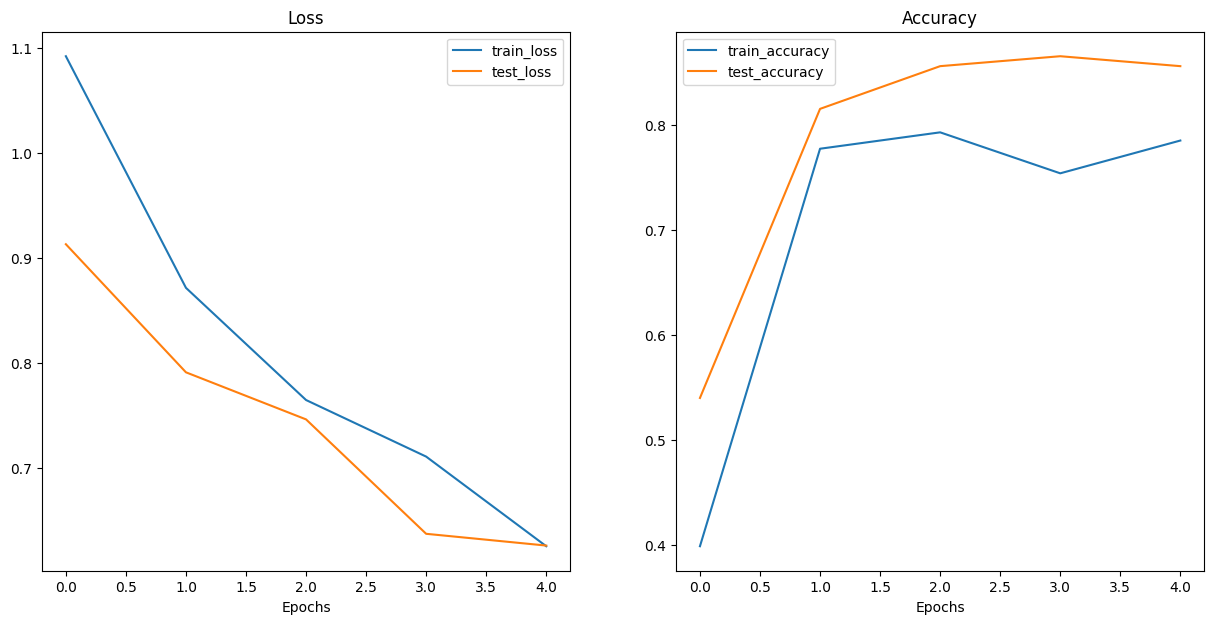

In [24]:
plot_loss_curves(results)

## 6. Fazendo predicoes com as imagens de teste

Modo explorador: *Visualize, Visualize, Visualize*!

Fazendo previsoes qualitativas nos dados de teste

Para fazer os  previcoes/inferencias  nios dados de test/custom eh necessario manter em mente: Ter centeza de que os dados:

* Mesmo shape - As imagens precisam ser do mesmo shape que o modelo foi treinado
* Mesmo datatype - Dados custom precisam ser do mesmo tipo
* Mesmo dispositivo - Dados custom/teste precisam estar no mesmo dispositivo que o modelo foi treinando
* Mesmas transformacoes - Se os dados custom/treino foram transformados, idelamente tu vai transformar os dados de teste/custom igual

Para fazer isso de maineira automatica iremos escrever a funcao `pred_and_plot_image()`:

Funcao similar a feita no notebook 04

1. Pegar o modelo treinado, a lista de classes, o caminho da imagem algo, o tamanho da imagem, o transform, e o dispositivo
2. Abrir a imagem com `PIL.Image.Open()`
3. Criar um transform, caso o mesmo ainda nao existe
4. Assegurar que o modelo esta no dispositivo certo
5. Colocar o modelo em modo `model.eval()` para ter certeza que esta pronto para inferencias(desligando coisas como a `nn.Dropout()`)
6. Transformar a imagem algo para garantir integridade de dimensoes com o modelo
7. Realizer a predicao na imagem passando pelo modelo
8. Converter a saida do modelo(logits -> pred probs) usando `torch.softmax()`
9. Converter as pred probs -> pred labels usando a `torch.argmax()`
10. Plotar a imagem com matplotlib e dar um titulo a label predita do passso 9 e a pred probs do passo 8






In [25]:
from re import S
from typing import List, Tuple
from PIL import Image

def pred_and_plot_image(model: torch.nn.Module,
                        image_path: str,
                        class_names: List[str],
                        image_size: Tuple[int, int] = (224, 224),
                        transform: torchvision.transforms = None,
                        device: torch.device=device):
  #Abrigando a imagem com PIL
  img = Image.open(image_path)

  #Criando os transformadores caso nao existam
  if transform is not None:
    image_transform = transform
  else:
    image_transform = transforms.Compose([
                                          transforms.Resize(image_size),
                                          transforms.ToTensor(),
                                          transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                                               std=[0.229, 0.224, 0.225])
    ])

  # Predizendo a imagem
  # 4. Device
  model.to(device)

  # 5. eval e einferencia
  model.eval()
  with torch.inference_mode():

    # 6. transformando o imagem e adicionanado uma dimensao de batch
    transformed_image = image_transform(img).unsqueeze(dim=0)

    # 7. REalizando a predicao na imagem transformada passando ela para o modelo
    target_image_pred = model(transformed_image.to(device))

  # 8. Convertendo as saidas logits do modelo em pred probs
  target_image_pred_probs = torch.softmax(target_image_pred, dim=1)

  # 9. Convertendo as pred probs em pred labels
  target_image_pred_label = torch.argmax(target_image_pred_probs, dim=1)

  # 10. Plotando a imagem com a label predita e a probabilidade
  plt.figure()
  plt.imshow(img)
  plt.title(f"Predicao; {class_names[target_image_pred_label]} | Probabilidade; {target_image_pred_probs.max():.3f}")
  plt.axis(False);

  # 8.

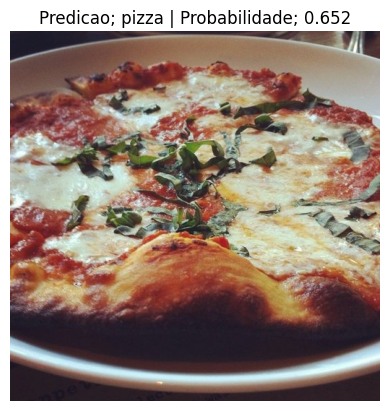

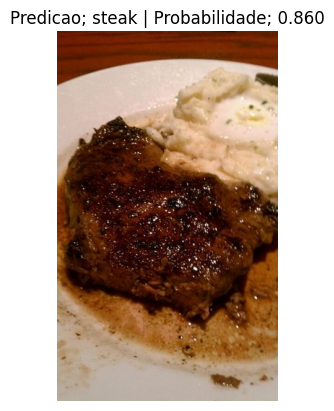

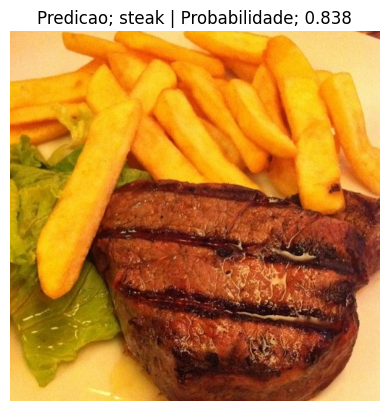

In [26]:
import random
num_images_to_plot = 3
test_image_path_list = list(Path(test_dir).glob("*/*.jpg"))
test_image_path_sample = random.sample(population=test_image_path_list,
                                       k=num_images_to_plot)
#Fazendo as predicoes e plotando a imagem
for image_path in test_image_path_sample:
  pred_and_plot_image(model=model,
                      image_path=image_path,
                      class_names=class_names,
                      image_size=(224, 224))

## Prevenda a imagem pizza-dad

In [27]:
import requests

#COnfigurando custom image_path
custom_image_path = data_path / "04-pizza-dad.jpeg"

#Download a imagem caso nao existe
if not custom_image_path.is_file():
  with open(custom_image_path, "wb") as f:
    request = requests.get("https://github.com/mrdbourke/pytorch-deep-learning/raw/main/images/04-pizza-dad.jpeg")
    print(f"Download: {custom_image_path}...")
    f.write(request.content)
else:
  print(f"{custom_image_path} ja existe, pulando download")

Download: data/04-pizza-dad.jpeg...


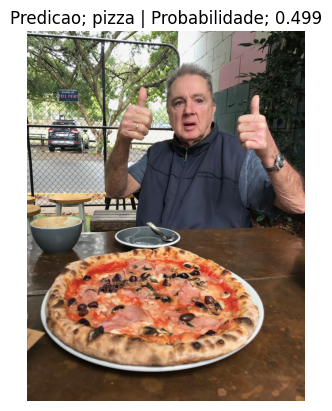

In [28]:
pred_and_plot_image(model=model,
                    image_path=custom_image_path,
                    class_names=class_names)